# BERT - Climate Sentiment Multiclass Classification
## CS522 Project

**Dataset:**  
https://www.kaggle.com/code/luiskalckstein/climate-sentiment-multiclass-classification

**Imports**

In [1]:
# ! pip install tensorflow-addons
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
from transformers import logging as hf_logging
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

from Common.DataCenter import data_center

hf_logging.set_verbosity_error()
warnings.filterwarnings('ignore')

%matplotlib inline

**Detect GPU**

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print('Set memory autoincrement')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print('Physical GPUs: %d, Logical GPUs: %d' % (len(gpus), len(logical_gpus)))
  except RuntimeError as e:
    print(e)
else:
    print('GPUs not detected')

Set memory autoincrement
Physical GPUs: 4, Logical GPUs: 4


2022-03-31 14:23:32.179122: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-31 14:23:46.870521: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21034 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:06:00.0, compute capability: 8.6
2022-03-31 14:23:46.872258: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21034 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:07:00.0, compute capability: 8.6
2022-03-31 14:23:46.873920: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/

## 1. Loading Dataset

In [3]:
def dc_format(D):
    data = {'message':D[0] , 'sentiment':D[1]}
    df = pd.DataFrame(data)
    return df

In [4]:
dc = data_center('./twitter_sentiment_data.csv', test_size=8000, noisy_size=8000, validation_size=5000)
test_df = dc_format(dc.get_test())
val_df = dc_format(dc.get_validation())

print(f"Test size: {test_df.shape[0]}")
print(f"Validation size: {val_df.shape[0]}")

Test size: 8000
Validation size: 5000


In [5]:
train_df_2000 = dc_format(dc.get_train(2000))
train_df_2500 = dc_format(dc.get_train(2500))
train_df_4000 = dc_format(dc.get_train(4000))
train_df_5000 = dc_format(dc.get_train(5000))
train_df_7500 = dc_format(dc.get_train(7500))
train_df_10000 = dc_format(dc.get_train(10000))

In [6]:
# [(2000, 500), (4000, 1000), (7500, 2500)]
train_df_2000_500 = dc_format(dc.get_train_with_noisy(2000, 500))
train_df_4000_1000 = dc_format(dc.get_train_with_noisy(4000, 1000))
train_df_7500_2500 = dc_format(dc.get_train_with_noisy(7500, 2500))

### <font color='red'> Specified training set </font>

In [215]:
train_df = train_df_7500_2500

In [216]:
train_df.head()

,message,sentiment
0,RT @MattWakhu: RT â@realDonaldTrump It's fre...,0
1,@MerrillLynched @EllenMorris1222 @zoobadger @h...,2
2,RT @kimeclipsed: Does anyone think global warm...,1
3,Budgeting for climate change in water resource...,2
4,17 U.S. communities are actively relocating du...,2


#### Label Encoding

In [217]:
le = LabelEncoder()
train_df['sparse_label'] = le.fit_transform(train_df['sentiment'])
val_df['sparse_label'] = le.transform(val_df['sentiment'])
test_df['sparse_label'] = le.transform(test_df['sentiment'])

In [218]:
label_dict = (train_df[['sentiment','sparse_label']].drop_duplicates()
              .sort_values(by='sparse_label')
              .reset_index(drop=True)['sentiment']
              .to_dict())

for index, key in label_dict.items():
    print(index, key)

0 0
1 1
2 2
3 3


#### Splitting dataset

In [219]:
x_train = train_df['message']
y_train = train_df['sparse_label']

x_val = val_df['message']
y_val = val_df['sparse_label']

print(f"{len(x_train)} training samples\n{len(x_val)} validation samples")

10000 training samples
5000 validation samples


In [220]:
x_test = test_df['message']
y_test = test_df['sparse_label']
print(f"{len(x_test)} testing samples")

8000 testing samples


## 2. Train BERT

In [221]:
MODEL_NAME = 'distilbert-base-uncased'

In [222]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

In [223]:
max_len = 0
for sentence in (x_train.tolist() + x_val.tolist()):
    try:
        sentence_token_len = len(tokenizer.tokenize(sentence))
        max_len = sentence_token_len if (sentence_token_len > max_len) else max_len
    except:
        pass
    
print(f"The maximum amount of tokens in the dataset is {max_len}")

The maximum amount of tokens in the dataset is 361


In [224]:
MAX_LEN = 365

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME,  
                                                add_special_tokens=True,
                                                max_length=MAX_LEN, 
                                                pad_to_max_length=True)

def tokenize(sentences):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, 
                                       add_special_tokens=True, 
                                       max_length=MAX_LEN, 
                                       pad_to_max_length=True, 
                                       return_attention_mask=True, 
                                       return_token_type_ids=True, 
                                       truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])       
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

In [225]:
X_train = tokenize(x_train)
X_val = tokenize(x_val)
X_test = tokenize(x_test)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:04<00:00, 1688.95it/s]


#### Add custom layers after embedding model for classification

In [226]:
bert_config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True)
TFBert = TFDistilBertModel.from_pretrained(MODEL_NAME, config=bert_config)

input_ids_layer = tf.keras.layers.Input(shape=(MAX_LEN,), name='input_token', dtype='int32')
input_masks_layer = tf.keras.layers.Input(shape=(MAX_LEN,), name='masked_token', dtype='int32') 

X = TFBert(input_ids = input_ids_layer, attention_mask = input_masks_layer)[0]
# X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(X)
# X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(X)
# X = tf.keras.layers.Dropout(0.3)(X)
X = tf.keras.layers.Dense(1024, activation=tfa.activations.mish)(X)
X = tf.keras.layers.Flatten()(X)
X = tf.keras.layers.Dense(4, activation=tf.nn.softmax)(X)

model = tf.keras.Model(inputs=[input_ids_layer, input_masks_layer], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = True

In [227]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 365)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 365)]        0           []                               
                                                                                                  
 tf_distil_bert_model_8 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 365, 768),                                                   
                                 hidden_states=((No                                         

#### Model callbacks

In [228]:
ckpt_dir = './ckpt'
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

In [229]:
model_checkpoint = ModelCheckpoint(filepath=ckpt_dir + '/weights_val_best.hdf5',
                                   monitor='val_accuracy',
                                   save_weights_only=True,
                                   save_best_only=True,
                                   verbose=0)

early_stopping = EarlyStopping(patience=3,
                               monitor='val_accuracy',
                               min_delta=0,
                               mode='min',
                               restore_best_weights=False,
                               verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              min_lr=0.000001,
                              patience=1,
                              mode='min',
                              factor=0.1,
                              min_delta=0.0001,
                              verbose=1)

In [230]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tfa.optimizers.RectifiedAdam(0.0001),
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/50
313/313 [==============================] - 116s 333ms/step - loss: 1.2473 - accuracy: 0.4705 - val_loss: 0.9848 - val_accuracy: 0.6050 - lr: 1.0000e-04
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 1.1000 - accuracy: 0.5583
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
313/313 [==============================] - 102s 326ms/step - loss: 1.1000 - accuracy: 0.5583 - val_loss: 1.0332 - val_accuracy: 0.5802 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - 103s 330ms/step - loss: 0.6635 - accuracy: 0.7601 - val_loss: 0.8741 - val_accuracy: 0.6618 - lr: 1.0000e-05
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 0.4584 - accuracy: 0.8451
Epoch 4: ReduceLROnPlateau reducing learning rate to 1e-06.
313/313 [==============================] - 102s 327ms/step - loss: 0.4584 - accuracy: 0.8451 - val_loss: 0.9306 - val_accuracy: 0.6480 - lr: 1.0000e-05
Epoch 5/50
313/313 [======================

In [231]:
def plot_graphs(history, metric, title=''):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history[metric],  label='Training')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title(title)
    plt.legend()
    plt.show()

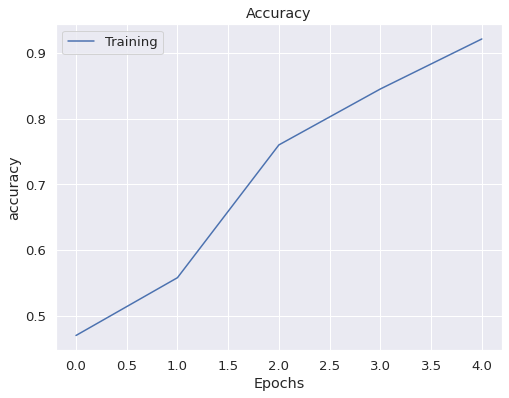

In [232]:
plot_graphs(history, 'accuracy', 'Accuracy')

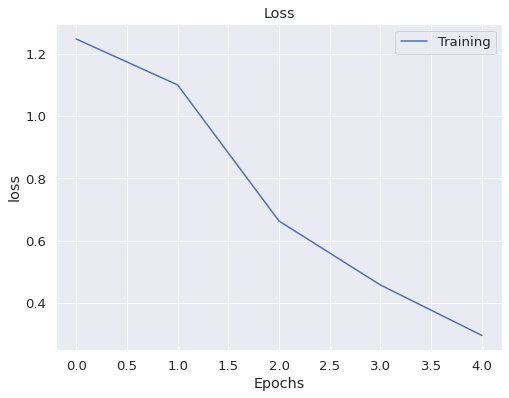

In [233]:
plot_graphs(history, 'loss', 'Loss')

#### Loading the best model and test on a test set

In [234]:
model.load_weights(ckpt_dir + '/weights_val_best.hdf5')

In [235]:
pred_probs = model.predict(X_test)
y_pred = np.argmax(pred_probs, axis=1)

#### Visualizing Confusion Matrix using Heatmap

In [236]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 305,  131,  246,   70],
       [ 149,  606,  529,  179],
       [ 212,  345, 3017,  442],
       [  49,   69,  287, 1364]])

Test Accuracy: 0.6615


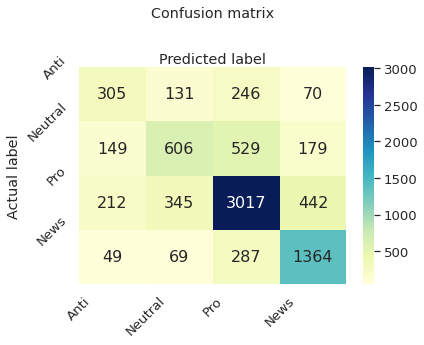

In [237]:
labels_names = ['Anti','Neutral','Pro','News'] 
class_names=[0, 1, 2, 3]

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

sns.set(font_scale = 1.2, color_codes=True, palette='deep')
sns.heatmap(pd.DataFrame(cm, index=labels_names ,columns=class_names), annot=True, annot_kws = {'size':16}, cmap='YlGnBu' ,fmt='g')
ax.xaxis.set_label_position('top')
plt.xticks(class_names, labels_names, rotation=45)
plt.yticks(class_names, labels_names, rotation=45)
plt.title('Confusion matrix', y=1.2)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('Test Accuracy:', accuracy_score(y_test, y_pred))

In [238]:
print(classification_report(y_test, y_pred, target_names=labels_names))

              precision    recall  f1-score   support

        Anti       0.43      0.41      0.42       752
     Neutral       0.53      0.41      0.46      1463
         Pro       0.74      0.75      0.75      4016
        News       0.66      0.77      0.71      1769

    accuracy                           0.66      8000
   macro avg       0.59      0.59      0.58      8000
weighted avg       0.65      0.66      0.66      8000



In [239]:
mf = f1_score(y_test, y_pred, average='macro')
wf = f1_score(y_test, y_pred, average='weighted')
mp = precision_score(y_test, y_pred, average='macro')
mr = recall_score(y_test, y_pred, average='macro')

In [240]:
print(
    f'Macro F1: {mf: .3f} \
    | Weighted F1: {wf: .3f} \
    | Macro Precision: {mp: .3f} \
    | Macro recall: {mr: .3f}'
)

Macro F1:  0.585     | Weighted F1:  0.656     | Macro Precision:  0.589     | Macro recall:  0.586
